Requires:
- cuda/10.1.243
- cudnn/v7.6.5

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.1


In [2]:
print("GPU is", "available" if len(tf.config.list_physical_devices('GPU')) > 0 else "NOT AVAILABLE")

GPU is available


/vulcanscratch/psando/envs/tf-828/lib64/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


image shape: (1, 224, 224, 3) label: notebook


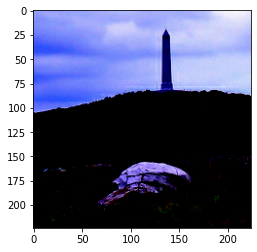

image shape: (1, 224, 224, 3) label: monastery


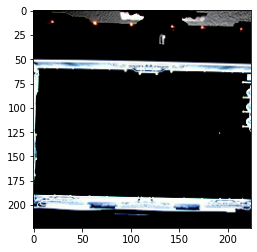

In [3]:
import os
from datetime import datetime
import tensorflow_datasets as tfds

# Get imagenet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

# Set data_dir to a read-only storage of .tar files
# Set write_dir to a w/r storage
data_dir = '/fs/vulcan-datasets/imagenet/'
write_dir = '/vulcanscratch/psando/tf-imagenet-dirs'

# Construct a tf.data.Dataset
download_config = tfds.download.DownloadConfig(
                      extract_dir=os.path.join(write_dir, 'extracted'),
                      manual_dir=data_dir
                  )
download_and_prepare_kwargs = {
    'download_dir': os.path.join(write_dir, 'downloaded'),
    'download_config': download_config,
}
ds = tfds.load('imagenet2012_subset', 
               data_dir=os.path.join(write_dir, 'data'),         
               split='train', 
               shuffle_files=False, 
               download=True, 
               as_supervised=True,
               download_and_prepare_kwargs=download_and_prepare_kwargs)

# Preprocess the images
def resize_with_crop(image, label):
    i = image
    i = tf.cast(i, tf.float32)
    i = tf.image.resize_with_crop_or_pad(i, 224, 224)
    i = tf.keras.applications.mobilenet_v2.preprocess_input(i)
    return (i, label)

ds = ds.map(resize_with_crop)

# Plot a few
ds = ds.batch(1).prefetch(tf.data.experimental.AUTOTUNE)
for example in ds.take(2):
    image, label = example
    print(f'image shape: {image.shape} label: {imagenet_labels[label]}')
    plt.imshow(tf.squeeze(image, axis=0))
    plt.show()

In [4]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False
pretrained_model.compile(optimizer='adam',
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

print("Evaluate model...")
result = pretrained_model.evaluate(ds)
print(dict(zip(pretrained_model.metrics_names, result)))

Evaluate model...
12811/12811 [==============================] - 167s 13ms/step - loss: 6.3519 - accuracy: 0.7188
{'loss': 6.351933479309082, 'accuracy': 0.7188353538513184}
